# Importación de datos

El objetivo de la aplicación será el reconocimiento de varias personas a la par que funcione como benhmark para los dispositivos móviles que se están evaluando.

Lo que debemos hacer es la "congelación" de una red neuronal para introducirle las clases que nos interesan detectar.

Primero de todo realizaremos los siguientes imports:

In [14]:
import tensorflow as tf
assert tf.__version__.startswith('2')

import os
import numpy as np
import matplotlib.pyplot as plt
import zipfile

Como este es un notebook en local, lo único que hará falta para descomprimir el fichero de las clases necesario, es colocarlo en la misma carpeta que el notebook, y ejecutar lo siguiente.

In [15]:
with zipfile.ZipFile('clases.zip', 'r') as zip_ref:
    zip_ref.extractall()
ruta = '.\clases'

A continuación, se generará los conjuntos de entrenamiento y validación. El tamaño de la imagen es de 224 porque la red que vamos a usar es ***MobileNet V2*** que acepta como input imágenes de ese tamaño.

In [16]:
IMAGE_SIZE = 224
BATCH_SIZE = 4

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    ruta,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    ruta,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

Found 130 images belonging to 4 classes.
Found 31 images belonging to 4 classes.


Vamos a ver la forma que tienen nuestro datos, el primero nos dirá el tamaño de lote (batch) y la forma de cada foto (224x224x3). El segundo nos dirá el tamaño de lote y el número de clases que tenemos.

In [17]:
image_batch, label_batch = train_generator[0]
image_batch.shape, label_batch.shape

((4, 224, 224, 3), (4, 4))

Vamos a mostrar el nombre de cada clase y lo guardaremos en un fichero .txt

In [18]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'Alberto': 0, 'Kio': 1, 'Marta': 2, 'undefined': 3}


# Creación del modelo

El modelo que se va a tomar de partida es el ***MobileNetV2*** desarrollado por Google, entrenado previamente en el dataset *ImageNet* que tiene 1.4M de fotos de 1000 distintas imágenes.

In [19]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

Lo se hará será conectar el modelo que tenemos hasta nuestras clases, pero tenemos dos opciones de hacerlo:
- La primera opción es mantener los pesos anteriores
- La segunda opción es actualizar los pesos de los anterior

Nosotros usaremos la primera opción, ya que nuestros ejemplos no son suficientemente amplios para modificar los pesos del modelo que nos viene preentrenado, para ello ponemos la variable *trainable* a ***False***.

In [20]:
base_model.trainable = False

Creamos nuestro modelo a partir del modelo base anterior, y añadiendo capas de neuronales para terminar en nuestras clases.

In [21]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(4, activation='softmax')
])

Es necesario compilar el modelo antes de entrenarlo

In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

Se muestra a continuación un resumen de la estructura de nuestro nuevo modelo.

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 132       
Total params: 2,626,788
Trainable params: 368,804
Non-trainable params: 2,257,984
_________________________________________________________________


# Entrenamiento del modelo

Una vez tenemos creado el modelo, lo entrenamos con las suficientes épocas para que ni genere *overfitting* ni *underfitting* .

In [24]:
epochs = 5

history = model.fit_generator(train_generator, 
                    epochs=epochs, 
                    validation_data=val_generator)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 33 steps, validate for 8 steps
Epoch 1/5
33/33 [==============================] - 24s 722ms/step - loss: 1.7457 - accuracy: 0.4615 - val_loss: 0.6642 - val_accuracy: 0.7097
Epoch 2/5
33/33 [==============================] - 19s 587ms/step - loss: 0.8074 - accuracy: 0.6538 - val_loss: 0.6905 - val_accuracy: 0.5806
Epoch 3/5
33/33 [==============================] - 18s 556ms/step - loss: 0.5906 - accuracy: 0.7385 - val_loss: 0.5384 - val_accuracy: 0.8387
Epoch 4/5
33/33 [==============================] - 19s 572ms/step - loss: 0.4650 - accuracy: 0.7846 - val_loss: 0.8592 - val_accuracy: 0.5484
Epoch 5/5
33/33 [==============================] - 18s 558ms/step - loss: 0.3612 - accuracy: 0.8462 - val_loss: 0.5012 - val_accuracy: 0.7419


Una vez entrenado, mostramos por pantalla su curva de aprendizaje

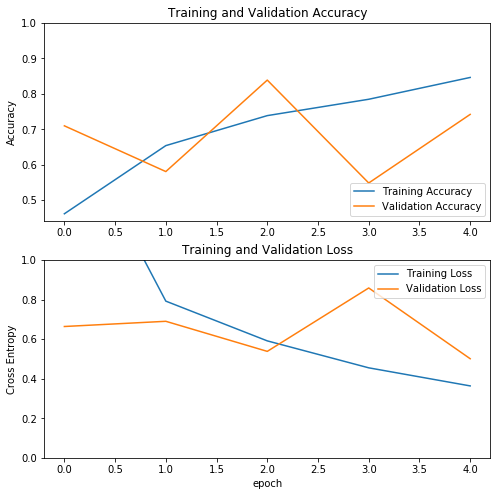

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Exportación del modelo a TFLite

In [26]:
saved_model_dir = './modelo/'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: ./modelo/assets
